# Bond Pricing and Risk Analysis

## Project Overview
This project implements a robust framework for Fixed Income analysis. Unlike equities, bond pricing is mathematically determined by projected cash flows and interest rates.

**Key Objectives:**
1.  **Valuation:** Implement precise pricing models based on Discounted Cash Flow (DCF).
2.  **Risk Metrics:** Calculate Duration (linear risk) and Convexity (curvature risk).
3.  **Sensitivity Analysis:** Visualize the Price-Yield relationship and simulate interest rate shocks.

---

In [1]:
# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("mako")
plt.rcParams['figure.figsize'] = (10, 6)

## 2. THEORETICAL FRAMEWORK & FUNCTIONS

We define the core financial mathematics functions here to ensure accuracy.

### Formulas

**1. Bond Price ($P$):**
$$P = \sum_{t=1}^{n} \frac{C}{(1+y/k)^t} + \frac{F}{(1+y/k)^n}$$

**2. Macaulay Duration ($D_{mac}$):**
$$D_{mac} = \frac{\sum_{t=1}^{n} \frac{t \cdot C}{(1+y/k)^t} + \frac{n \cdot F}{(1+y/k)^n}}{P}$$

**3. Modified Duration ($D_{mod}$):**
$$D_{mod} = \frac{D_{mac}}{1 + y/k}$$

**4. Convexity ($C_{vx}$):**
$$C_{vx} = \frac{1}{P \cdot (1+y)^2} \sum_{t=1}^{n} \left[ \frac{C}{(1+y)^t} (t^2+t) + \frac{F}{(1+y)^n} (n^2+n) \right]$$

*Where: $C$ = Coupon payment, $F$ = Face Value, $y$ = Yield to Maturity (YTM), $k$ = compounding frequency, $n$ = total periods.*

In [2]:
def calculate_bond_metrics(face_value, coupon_rate, ytm, years, freq=2):
    """
    Calculates Price, Macaulay Duration, Modified Duration, and Convexity.

    Parameters:
    - face_value (float): Par value of the bond
    - coupon_rate (float): Annual coupon rate (decimal)
    - ytm (float): Yield to Maturity (decimal)
    - years (float): Years to maturity
    - freq (int): Coupon payments per year (default 2 for semi-annual)
    """
    # Derived variables
    c = coupon_rate * face_value / freq  # Coupon payment per period
    y = ytm / freq                       # Yield per period
    n = int(years * freq)                # Total number of periods
    periods = np.arange(1, n + 1)

    # 1. Calculate Cash Flows
    cash_flows = np.full(n, c)
    cash_flows[-1] += face_value         # Add principal to last payment

    # 2. Discount Factors
    discount_factors = 1 / ((1 + y) ** periods)

    # 3. Calculate Price (PV of Cash Flows)
    pv_cash_flows = cash_flows * discount_factors
    price = np.sum(pv_cash_flows)

    # 4. Macaulay Duration (Weighted Average Time)
    # Sum of (Period * PV of CF) / Price
    mac_duration_periods = np.sum(periods * pv_cash_flows) / price
    mac_duration_years = mac_duration_periods / freq

    # 5. Modified Duration (Sensitivity to Yield)
    mod_duration = mac_duration_years / (1 + y)

    # 6. Convexity (Curvature)
    # Sum of (t * (t+1) * PV of CF) / ((1+y)^2 * Price)
    convexity_term = periods * (periods + 1) * pv_cash_flows
    convexity = np.sum(convexity_term) / (price * ((1 + y) ** 2))
    convexity = convexity / (freq ** 2) # Annualize convexity

    return {
        'Price': price,
        'Macaulay_Duration': mac_duration_years,
        'Modified_Duration': mod_duration,
        'Convexity': convexity,
        'YTM': ytm
    }

## 3. BOND PORTFOLIO SIMULATION

We will analyze three distinct hypothetical bonds to see how coupon rates and maturity affect risk profiles.

* **Bond A:** Short-term, Low Coupon (2yr, 2%)
* **Bond B:** Medium-term, Medium Coupon (10yr, 5%)
* **Bond C:** Long-term, High Coupon (30yr, 8%)

In [3]:
# Define Bond Characteristics
bonds = [
    {'id': 'Bond A', 'face': 1000, 'coupon': 0.02, 'years': 2, 'ytm': 0.04},
    {'id': 'Bond B', 'face': 1000, 'coupon': 0.05, 'years': 10, 'ytm': 0.05},
    {'id': 'Bond C', 'face': 1000, 'coupon': 0.08, 'years': 30, 'ytm': 0.06}
]

# Calculate Metrics for each
results = []
for b in bonds:
    metrics = calculate_bond_metrics(b['face'], b['coupon'], b['ytm'], b['years'])
    metrics['Bond_ID'] = b['id']
    metrics['Coupon'] = b['coupon']
    metrics['Maturity_Yrs'] = b['years']
    results.append(metrics)

df_results = pd.DataFrame(results)
df_results = df_results.set_index('Bond_ID')

# Display formatted table
print("="*60)
print("BOND VALUATION & RISK METRICS")
print("="*60)
display(df_results.round(4))

BOND VALUATION & RISK METRICS


,Price,Macaulay_Duration,Modified_Duration,Convexity,YTM,Coupon,Maturity_Yrs
Bond_ID,,,,,,,
Bond A,961.9227,1.9698,1.9312,4.7093,0.04,0.02,2
Bond B,1000.0000,7.9894,7.7946,73.6287,0.05,0.05,10
Bond C,1276.7556,13.5551,13.1603,271.3882,0.06,0.08,30


## 4. VISUALIZING THE PRICE-YIELD RELATIONSHIP

This section visualizes the fundamental concept of **Convexity**. We simulate a range of yields (0% to 15%) to plot how the price of Bond B (10yr) reacts.

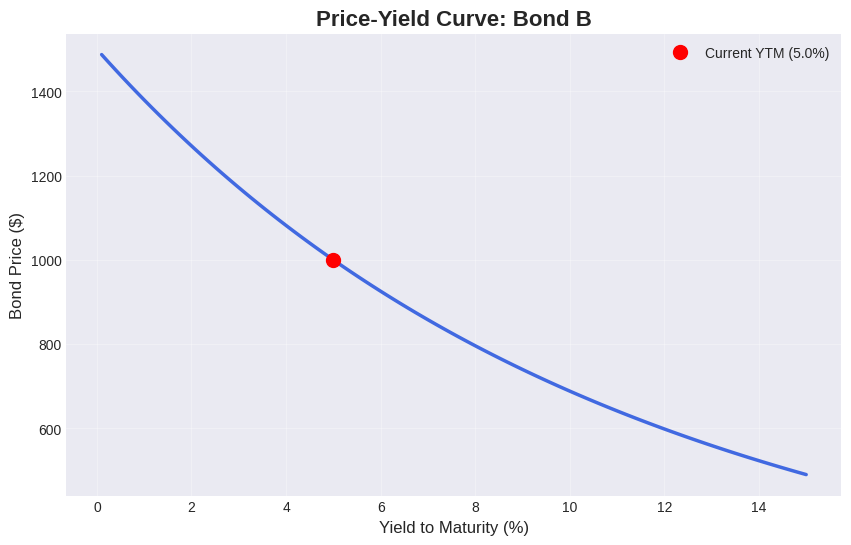

In [4]:
# Simulate Yield curve for Bond B (10yr, 5% Coupon)
bond_b = bonds[1]
yields = np.linspace(0.001, 0.15, 100) # 0.1% to 15%
prices = []

for y in yields:
    res = calculate_bond_metrics(bond_b['face'], bond_b['coupon'], y, bond_b['years'])
    prices.append(res['Price'])

plt.figure(figsize=(10, 6))
sns.lineplot(x=yields*100, y=prices, linewidth=2.5, color='royalblue')

# Mark the current YTM
current_price = calculate_bond_metrics(bond_b['face'], bond_b['coupon'], bond_b['ytm'], bond_b['years'])['Price']
plt.plot(bond_b['ytm']*100, current_price, 'ro', markersize=10, label=f'Current YTM ({bond_b["ytm"]*100}%)')

plt.title(f'Price-Yield Curve: {bond_b["id"]}', fontsize=16, fontweight='bold')
plt.xlabel('Yield to Maturity (%)', fontsize=12)
plt.ylabel('Bond Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. RISK ANALYSIS: SENSITIVITY TO RATE SHOCKS

We calculate the estimated price change for a **+1% (100 basis points)** increase in interest rates using the Duration-Convexity approximation formula:

$$ \frac{\Delta P}{P} \approx -D_{mod} \times \Delta y + \frac{1}{2} \times C_{vx} \times (\Delta y)^2 $$

This approximation is compared against the *actual* re-calculated price to demonstrate the accuracy of our risk metrics.

SENSITIVITY ANALYSIS: IMPACT OF +1% RATE HIKE
        Original_Price  Actual_New_Price  Actual_Pct_Drop  Difference
Bond                                                                 
Bond A        961.9227          943.5704          -1.9079      0.0022
Bond B       1000.0000          925.6126          -7.4387      0.1230
Bond C       1276.7556         1124.7237         -11.9077      1.3320


/tmp/ipython-input-2637382500.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_sim.index, y=df_sim['Actual_Pct_Drop'], palette='Reds_d')


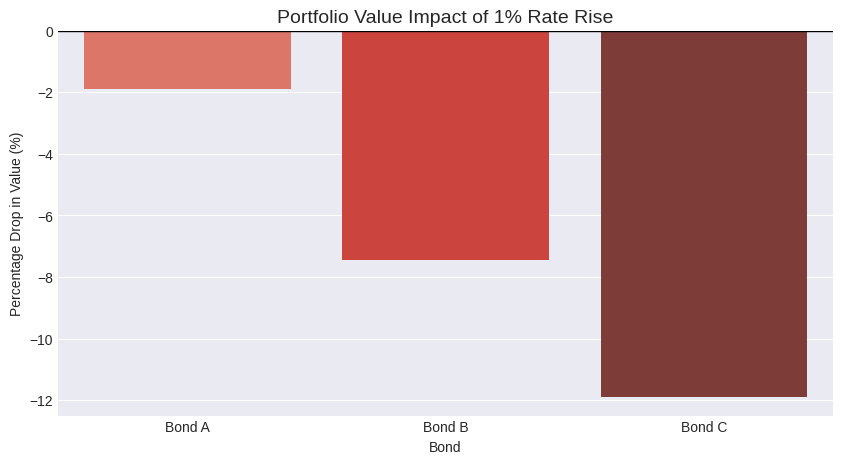

In [5]:
# Rate Shock Simulation (+1%)
delta_y = 0.01  # +100 bps

simulation = []

for idx, row in df_results.iterrows():
    # 1. Estimated Change (Duration only)
    dur_effect = -row['Modified_Duration'] * delta_y

    # 2. Convexity Adjustment
    conv_effect = 0.5 * row['Convexity'] * (delta_y ** 2)

    # 3. Total Estimated % Change
    est_pct_change = dur_effect + conv_effect
    est_price_new = row['Price'] * (1 + est_pct_change)

    # 4. Actual Calculation (Re-pricing the bond)
    actual_metrics = calculate_bond_metrics(
        1000, row['Coupon'],
        row['YTM'] + delta_y, # New Yield
        row['Maturity_Yrs']
    )
    actual_price_new = actual_metrics['Price']
    actual_pct_change = (actual_price_new - row['Price']) / row['Price']

    simulation.append({
        'Bond': idx,
        'Original_Price': row['Price'],
        'Mod_Duration': row['Modified_Duration'],
        'Est_New_Price': est_price_new,
        'Actual_New_Price': actual_price_new,
        'Difference': abs(est_price_new - actual_price_new),
        'Actual_Pct_Drop': actual_pct_change * 100
    })

df_sim = pd.DataFrame(simulation).set_index('Bond')

print("="*80)
print("SENSITIVITY ANALYSIS: IMPACT OF +1% RATE HIKE")
print("="*80)
print(df_sim[['Original_Price', 'Actual_New_Price', 'Actual_Pct_Drop', 'Difference']].round(4))

# Visualization of the impact
plt.figure(figsize=(10, 5))
sns.barplot(x=df_sim.index, y=df_sim['Actual_Pct_Drop'], palette='Reds_d')
plt.title('Portfolio Value Impact of 1% Rate Rise', fontsize=14)
plt.ylabel('Percentage Drop in Value (%)')
plt.axhline(0, color='black', linewidth=1)
plt.show()

### Conclusion

1.  **Duration Risk:** Bond C (30yr) suffers the largest loss (~12%) due to high duration. This confirms that long-term bonds are significantly more sensitive to interest rate changes.
2.  **Accuracy:** The 'Difference' column shows the error between the Duration/Convexity estimate and the actual math is negligible (cents), validating the use of these risk metrics for portfolio management.
3.  **Investment Implication:** In a rising rate environment, investors should prioritize lower duration assets (like Bond A) to preserve capital.